# Import relevant libraries

Imports the relevant python libraries needed.

In [1]:
import yahoo_fin
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt

# Import and preprocess data

Data is scraped from Yahoo!Finance for all S&P 500 companies using the yahoo_fin Python library.

The below extracts the list of S&P500 companies' tickers. 2 of the tickers' values were replaced so that they can be searched using the yahoo_fin library.

In [2]:
sp500_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', attrs={'class': 'wikitable sortable'},header=0)[0]['Symbol']
sp500_list.replace(to_replace='BRK.B',value='BRK-B',inplace=True)
sp500_list.replace(to_replace='BF.B',value='BF-B',inplace=True)

The below extracts the information from Yahoo!Finance according to the start date and end date specified. Information for each ticker is extracted for the 'daily' time interval.

In [3]:
#Variables created.
historical_data = {}
counter = 0
key_err = 0
assert_err = 0
tickers_key_err = []
tickers_assert_err= []

#User input - start date and end date
while True:
    try:
        start_date_input = input("Please enter START date for the date range you want the model to be trained on. Format of input: DD-MM-YY.")
        start_date = datetime.strptime(start_date_input, '%d-%m-%y')
        print("Start date: " + str(start_date_input))
        break
    except ValueError:
        print("                             ", end='\r')
        print("Please ensure input is in the format DD-MM-YY.", end='\r')

while True:
    try:
        end_date_input = input("Please enter END date for the date range you want the model to be trained on. Format of input: DD-MM-YY.")
        end_date = datetime.strptime(end_date_input, '%d-%m-%y')
        print("End date: " + str(end_date_input))
        break
    except ValueError:
        print("                             ", end='\r')
        print("Please ensure input is in the format DD-MM-YY.", end='\r')


for ticker in sp500_list:
    counter += 1
    print("                             ", end='\r')
    print(str(ticker) + " " + str(counter), end='\r')
    try:
        historical_data[ticker] = get_data(ticker, start_date = start_date_input, end_date = end_date_input)
        historical_data[ticker] = historical_data[ticker].drop(labels='ticker',axis=1)
        historical_data[ticker].columns = str(ticker) + "_" + historical_data[ticker].columns
        
    except KeyError:
        historical_data[ticker] = None
        key_err += 1
        tickers_key_err.append(ticker)
    except AssertionError:
        historical_data[ticker] = None
        assert_err += 1
        tickers_assert_err.append(ticker)
        
print("No. of stocks with data successfully generated: " + str(counter-key_err-assert_err) + ".")
print("No. of stocks with KeyError: " + str(key_err) + ".")
if key_err>0:
    print("Tickers with KeyError (to investigate if needed): " + str(tickers_key_err))
print("No. of stocks with AssertionError: " + str(assert_err) + ".")
if assert_err>0:
    print("Tickers with AssertionError (to investigate if needed): " + str(tickers_assert_err))

Please enter START date for the date range you want the model to be trained on. Format of input: DD-MM-YY.01-01-00
Start date: 01-01-00
Please enter END date for the date range you want the model to be trained on. Format of input: DD-MM-YY.30-11-20
End date: 30-11-20
No. of stocks with data successfully generated: 505.
No. of stocks with KeyError: 0.
No. of stocks with AssertionError: 0.


Merge the dictionary of dataframes column-wise on the index (which is the date). Drop all columns with NaN values.

In [4]:
merged_data = pd.concat(historical_data, axis=1)
merged_data = merged_data.dropna(axis='columns')
merged_tickers = list(set(merged_data.columns.get_level_values(0))) #Store all remaining tickers' names for further use later.
merged_data.columns = merged_data.columns.droplevel(0)

merged_data.head()



,MMM_open,MMM_high,MMM_low,MMM_close,MMM_adjclose,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,...,ZBRA_low,ZBRA_close,ZBRA_adjclose,ZBRA_volume,ZION_open,ZION_high,ZION_low,ZION_close,ZION_adjclose,ZION_volume
2000-01-03,48.03125,48.25000,47.03125,47.1875,27.815882,2173400,15.823756,16.160431,15.599305,15.711531,...,24.777779,25.027779,25.027779,1055700,59.03125,59.1250,53.4375,55.5000,39.996193,1199600
2000-01-04,46.43750,47.40625,45.31250,45.3125,26.710594,2713800,15.459024,15.599305,15.150405,15.262630,...,23.000000,24.666666,24.666666,522400,54.62500,55.0000,52.5000,52.8125,38.059437,816100
2000-01-05,45.56250,48.12500,45.56250,46.6250,27.484299,3699400,15.066236,15.402911,15.066236,15.234573,...,23.555555,25.138889,25.138889,612100,52.75000,53.2500,51.0625,52.7500,38.014412,1124700
2000-01-06,47.15625,51.25000,47.15625,50.3750,29.694832,5975800,15.262630,15.823756,15.178461,15.767643,...,23.722221,23.777779,23.777779,263800,52.75000,54.9375,52.3750,53.5000,38.554890,1112100
2000-01-07,50.56250,51.90625,49.96875,51.3750,30.284302,4101200,15.487081,16.272657,15.487081,15.935981,...,23.111111,23.513889,23.513889,333900,53.75000,54.2500,53.3125,53.6250,38.644981,782000


# Picking of target stock

User to pick the target stock out of the remaining tickers in the pre-processed data for training and testing of the model.

In [5]:
print("List of all tickers in data: \n" + str(merged_tickers))
chosen_ticker = input("Indicate a ticker. Pick one from the print statement below.")
chosen_adjclose = chosen_ticker + "_adjclose"

List of all tickers in data: 
['BF-B', 'EMN', 'COF', 'MTD', 'RCL', 'SEE', 'CSX', 'MCK', 'DLTR', 'CI', 'OXY', 'BSX', 'FMC', 'WMT', 'TFX', 'PFE', 'MMM', 'A', 'WAT', 'MSI', 'DTE', 'GIS', 'EBAY', 'JKHY', 'PAYX', 'FFIV', 'LHX', 'OKE', 'EMR', 'SCHW', 'HFC', 'ROK', 'NOV', 'PHM', 'HOLX', 'ALB', 'VMC', 'TXT', 'DOV', 'SLB', 'TRV', 'IBM', 'BA', 'EOG', 'RSG', 'AMAT', 'OMC', 'EVRG', 'CVS', 'BKNG', 'SPG', 'MKC', 'INTC', 'VFC', 'LIN', 'BIIB', 'PPG', 'BDX', 'D', 'CTSH', 'FISV', 'IFF', 'AXP', 'AMGN', 'LEN', 'KIM', 'WHR', 'AMZN', 'GLW', 'XOM', 'CMA', 'JPM', 'AVB', 'DVN', 'ATVI', 'WEC', 'VLO', 'LH', 'MO', 'RE', 'GWW', 'ZBRA', 'LOW', 'COG', 'URI', 'PEAK', 'CHD', 'PEG', 'RF', 'APA', 'VAR', 'UNM', 'PG', 'DISH', 'FAST', 'MCD', 'ATO', 'CAG', 'K', 'EL', 'YUM', 'PH', 'ES', 'SNPS', 'CPB', 'ECL', 'GD', 'MU', 'HES', 'ARE', 'STT', 'TROW', 'CMI', 'JNPR', 'SNA', 'ORLY', 'AMD', 'FRT', 'PKI', 'WELL', 'AOS', 'CPRT', 'APD', 'FDX', 'HSY', 'CMS', 'NVDA', 'AFL', 'SWK', 'L', 'HUM', 'XLNX', 'HIG', 'BWA', 'RHI', 'WBA', 'CAH', 

# Exploratory Data Analysis and Feature Selection

Plot of price over time period for chosen stock's adjusted close and open prices.

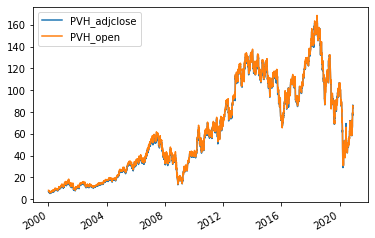

In [6]:

%matplotlib inline
merged_data[chosen_adjclose].plot()
merged_data[chosen_ticker+"_open"].plot()
plt.legend()

Summary statistics over entire time period for chosen stock using pandas' describe function.

In [7]:
print(merged_data[chosen_adjclose].describe())

count    5261.000000
mean       62.258707
std        42.630146
min         5.307689
25%        22.210590
50%        53.264847
75%       102.160294
max       167.603027
Name: PVH_adjclose, dtype: float64


Pick variables based on the correlation coefficient of chosen_adjclose ("target variable") vs all other variables ("feature variables").

In [8]:
r = [np.corrcoef(merged_data[chosen_adjclose],merged_data[column])[0,1] for column in merged_data]
days_ahead = int(input("How many days ahead would you like to predict?"))
features = merged_data[merged_data.columns[np.argpartition(np.abs(r), -200)[-200:]]].shift(days_ahead).dropna()
target = merged_data[chosen_adjclose][days_ahead:]


How many days ahead would you like to predict?1


Determine the proportion of the split between train and test set. Here, arbitrarily determined as 90% for training, 10% for testing. Note: For extremely large data sets, it may be good to specify a number value (as opposed to a percentage) for the test set as the test set need not be too large, and also it would be good for the training set to be larger where possible.


In [9]:
traintest_index = int(len(features) * 0.9) #This returns the row number for the boundary between train and test sets.
traintest_value = features.index[traintest_index] #This returns the datetimeindex at the row where we want to split between train and test sets.
features_train = features[features.index <= traintest_value]
features_test = features[features.index > traintest_value]
target_train = target[target.index <= traintest_value]
target_test = target[target.index > traintest_value]

print("Check of train-test split: ")
print("features = " + str(len(features)))
print("features_train = " + str(len(features_train)))
print("features_test = " + str(len(features_test)))


Check of train-test split: 
features = 5260
features_train = 4735
features_test = 525


Perform a min-max scaling on the features for both train and test sets using sklearn's MinMaxScaler module to ensure that data is all within the same scale.

In [11]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
features_train = pd.DataFrame(minmax_scaler.fit_transform(features_train), 
                              columns = features_train.columns, 
                              index = features_train.index)
features_train.head()

,CB_high,PPG_low,D_high,MCK_adjclose,MCK_open,MCK_high,AVB_low,MCK_close,MCK_low,BIIB_close,...,PXD_high,PXD_open,PNR_adjclose,PNR_close,PNR_low,PNR_high,PNR_open,OKE_close,OKE_low,OKE_open
2000-01-04,0.015344,0.149067,0.024101,0.028542,0.030222,0.031372,0.007283,0.032534,0.027378,0.026175,...,0.004132,0.006360,0.074344,0.105017,0.097971,0.117427,0.120640,0.010059,0.009473,0.011032
2000-01-05,0.009206,0.140480,0.025028,0.022697,0.030771,0.029171,0.001917,0.025917,0.025442,0.021570,...,0.003856,0.005530,0.071507,0.101127,0.098838,0.102803,0.105991,0.009032,0.008649,0.009193
2000-01-06,0.008768,0.141368,0.036615,0.023671,0.026101,0.025869,0.000000,0.027020,0.024336,0.025993,...,0.004682,0.006636,0.074344,0.105017,0.100572,0.103663,0.100820,0.009853,0.009061,0.009193
2000-01-07,0.008768,0.151435,0.039859,0.029760,0.026375,0.034124,0.004217,0.033912,0.026825,0.029003,...,0.004682,0.005254,0.073398,0.103720,0.101873,0.101082,0.102975,0.009853,0.009267,0.009602
2000-01-10,0.028496,0.166240,0.038469,0.028785,0.034343,0.034124,0.012650,0.032809,0.032080,0.037165,...,0.004958,0.006360,0.080647,0.113660,0.106208,0.112266,0.105129,0.012933,0.010296,0.009806


In [12]:
features_test = pd.DataFrame(minmax_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)
features_test.head()

,CB_high,PPG_low,D_high,MCK_adjclose,MCK_open,MCK_high,AVB_low,MCK_close,MCK_low,BIIB_close,...,PXD_high,PXD_open,PNR_adjclose,PNR_close,PNR_low,PNR_high,PNR_open,OKE_close,OKE_low,OKE_open
2018-10-29,124.660004,101.070000,73.580002,115.404144,120.970001,121.000000,173.199997,118.389999,117.190002,300.170013,...,152.880005,151.000000,37.924793,39.349998,38.230000,39.750000,38.369999,63.340000,62.459999,64.269997
2018-10-30,125.510002,101.410004,72.790001,117.724136,120.250000,122.230003,175.830002,120.769997,119.459999,300.959991,...,150.360001,150.220001,37.654942,39.070000,38.660000,40.060001,39.889999,63.230000,62.459999,63.900002
2018-10-31,125.529999,102.120003,72.940002,120.989647,121.250000,124.199997,177.210007,124.120003,120.209999,306.279999,...,146.179993,142.270004,38.377773,39.820000,39.090000,40.009998,39.380001,63.270000,62.200001,63.209999
2018-11-01,126.500000,104.239998,72.610001,121.613503,124.889999,125.980003,174.399994,124.760002,123.629997,304.269989,...,150.630005,147.770004,38.695824,40.150002,39.930000,40.639999,40.310001,65.599998,64.500000,64.709999
2018-11-02,126.430000,105.089996,72.440002,125.834305,125.480003,129.199997,174.389999,129.089996,125.410004,315.329987,...,151.889999,147.429993,39.649963,41.139999,40.099998,41.240002,40.340000,64.809998,64.099998,65.919998


Sequence generation

In [13]:
sequence_length = 5
def gen_sequence(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

seq_array = np.array(list(gen_sequence(features_train,sequence_length)))
seq_array.shape

(4730, 5, 200)

In [14]:
def gen_labels(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

label_array = np.array(list(gen_labels(target_train,sequence_length)))
label_array.shape

(4730,)

In [15]:
seq_array_test = np.array(list(gen_sequence(features_test,sequence_length)))
seq_array_test.shape

(520, 5, 200)

In [16]:
label_array_test = np.array(list(gen_labels(target_test,sequence_length)))
label_array_test.shape

(520,)

# Benchmark Model - Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()
linearregression.fit(np.array([seq_array[i][sequence_length-1] for i in range(seq_array.shape[0])]),label_array)

LinearRegression()

In [18]:
prediction = linearregression.predict(np.array([seq_array_test[i][sequence_length-1] for i in range(seq_array_test.shape[0])]))


In [19]:
pd.DataFrame([prediction,label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index> target.index[int(len(target) * 0.9) + sequence_length]])\
.to_csv('LR_prediction.csv')

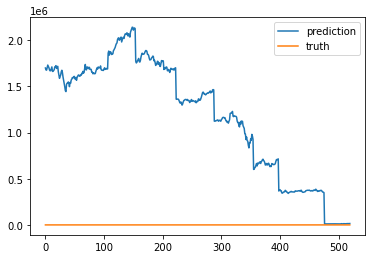

In [20]:
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(-2698002392.3174253, 1334104.31247216)

# Neural Network

LSTM model

In [22]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='nadam', metrics=['mean_squared_error'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            120400    
_________________________________________________________________
dropout (Dropout)            (None, 5, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [24]:
history = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

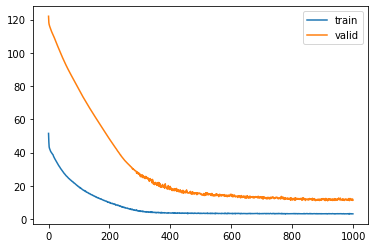

In [25]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [26]:
pd.DataFrame([history.history['loss'],history.history['val_loss']]).T\
.rename({0:'train',1:'test'},axis=1)\
.to_csv('history.csv')

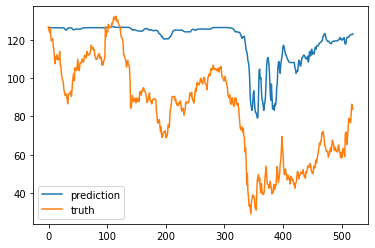

In [27]:
prediction = model.predict(seq_array_test)
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [28]:
pd.DataFrame([np.squeeze(prediction),label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index> target.index[int(len(target) * 0.9) + sequence_length]])\
.to_csv('LSTM_prediction.csv')

In [29]:
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(-1.5486262799783823, 41.00357290348114)